<a href="https://colab.research.google.com/github/bsst13/Customer-Segmentation-with-Clustering/blob/main/%5BGithub%5D_Detecting_the_anomalous_activity_of_a_ship's_engine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Initial Data Exploration and Assessment**

In [ ]:
# Import the necessary libraries.
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# URL to import data set from GitHub.
# url = 'https://raw.githubusercontent.com/fourthrevlxd/cam_dsb/main/engine.csv'
data = pd.read_csv('https://raw.githubusercontent.com/fourthrevlxd/cam_dsb/main/engine.csv')

# Display the first few rows of the data set.
print(data.shape)
data.head()

(19535, 6)


,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp
0,682,2.391656,4.617196,2.848982,76.272417,69.884609
1,605,5.466877,6.424361,5.727520,73.222679,74.907314
2,658,3.434232,3.680896,1.678708,88.089916,78.704806
3,749,2.094656,7.120927,1.639670,77.661625,82.386700
4,676,3.538228,5.956472,3.225336,75.226352,67.153220


In [ ]:
#check for missing values
data.isnull().sum()

,0
Engine rpm,0
Lub oil pressure,0
Fuel pressure,0
Coolant pressure,0
lub oil temp,0
Coolant temp,0


In [ ]:
#check for duplicated values
data.duplicated().sum()

np.int64(0)

In [ ]:
#Generate descriptive statistics (mean, median).
desc = data.describe().T
desc['median'] = data.median()
desc = desc[['count','mean','median','std','min','25%','50%','75%','max']]
display(desc)

,count,mean,median,std,min,25%,50%,75%,max
Engine rpm,19535.0,791.239263,746.000000,267.611193,61.000000,593.000000,746.000000,934.000000,2239.000000
Lub oil pressure,19535.0,3.303775,3.162035,1.021643,0.003384,2.518815,3.162035,4.055272,7.265566
Fuel pressure,19535.0,6.655615,6.201720,2.761021,0.003187,4.916886,6.201720,7.744973,21.138326
Coolant pressure,19535.0,2.335369,2.166883,1.036382,0.002483,1.600466,2.166883,2.848840,7.478505
lub oil temp,19535.0,77.643420,76.817350,3.110984,71.321974,75.725990,76.817350,78.071691,89.580796
Coolant temp,19535.0,78.427433,78.346662,6.206749,61.673325,73.895421,78.346662,82.915411,195.527912


In [ ]:
# Add 95th percentile
desc['95%'] = data.quantile(0.95)
display(desc)

,count,mean,median,std,min,25%,50%,75%,max,95%
Engine rpm,19535.0,791.239263,746.000000,267.611193,61.000000,593.000000,746.000000,934.000000,2239.000000,1324.000000
Lub oil pressure,19535.0,3.303775,3.162035,1.021643,0.003384,2.518815,3.162035,4.055272,7.265566,5.058040
Fuel pressure,19535.0,6.655615,6.201720,2.761021,0.003187,4.916886,6.201720,7.744973,21.138326,12.208475
Coolant pressure,19535.0,2.335369,2.166883,1.036382,0.002483,1.600466,2.166883,2.848840,7.478505,4.438415
lub oil temp,19535.0,77.643420,76.817350,3.110984,71.321974,75.725990,76.817350,78.071691,89.580796,84.940778
Coolant temp,19535.0,78.427433,78.346662,6.206749,61.673325,73.895421,78.346662,82.915411,195.527912,88.612891


In [ ]:
#Identify values beyond 95th percentile for at least two features
for col in data[:2]:
    cutoff = data[col].quantile(0.95)
    beyond = data[data[col] > cutoff][col]
    print(f"\nFeature: {col} 95th pct cutoff = {cutoff}")
    print("Number of rows beyond 95th pct:", beyond.shape[0])
    display(data.loc[data[col] > cutoff, [col]].head())


Feature: Engine rpm 95th pct cutoff = 1324.0
Number of rows beyond 95th pct: 974


,Engine rpm
23,1411
35,1374
73,1438
76,1399
99,1347



Feature: Lub oil pressure 95th pct cutoff = 5.0580398327
Number of rows beyond 95th pct: 977


,Lub oil pressure
1,5.466877
7,5.495972
12,5.336469
17,5.963439
52,5.618394



Feature: Fuel pressure 95th pct cutoff = 12.208474577999997
Number of rows beyond 95th pct: 977


,Fuel pressure
6,15.499680
7,13.114658
9,21.138326
72,13.739860
90,13.944291



Feature: Coolant pressure 95th pct cutoff = 4.438414563599999
Number of rows beyond 95th pct: 977


,Coolant pressure
1,5.727520
17,5.931953
39,5.788750
55,4.594904
98,6.197552



Feature: lub oil temp 95th pct cutoff = 84.94077776900001
Number of rows beyond 95th pct: 977


,lub oil temp
2,88.089916
13,88.038301
16,86.485544
27,86.667679
113,85.053243



Feature: Coolant temp 95th pct cutoff = 88.612891046
Number of rows beyond 95th pct: 977


,Coolant temp
17,88.661972
43,91.095461
44,91.078753
123,88.938037
141,89.417527


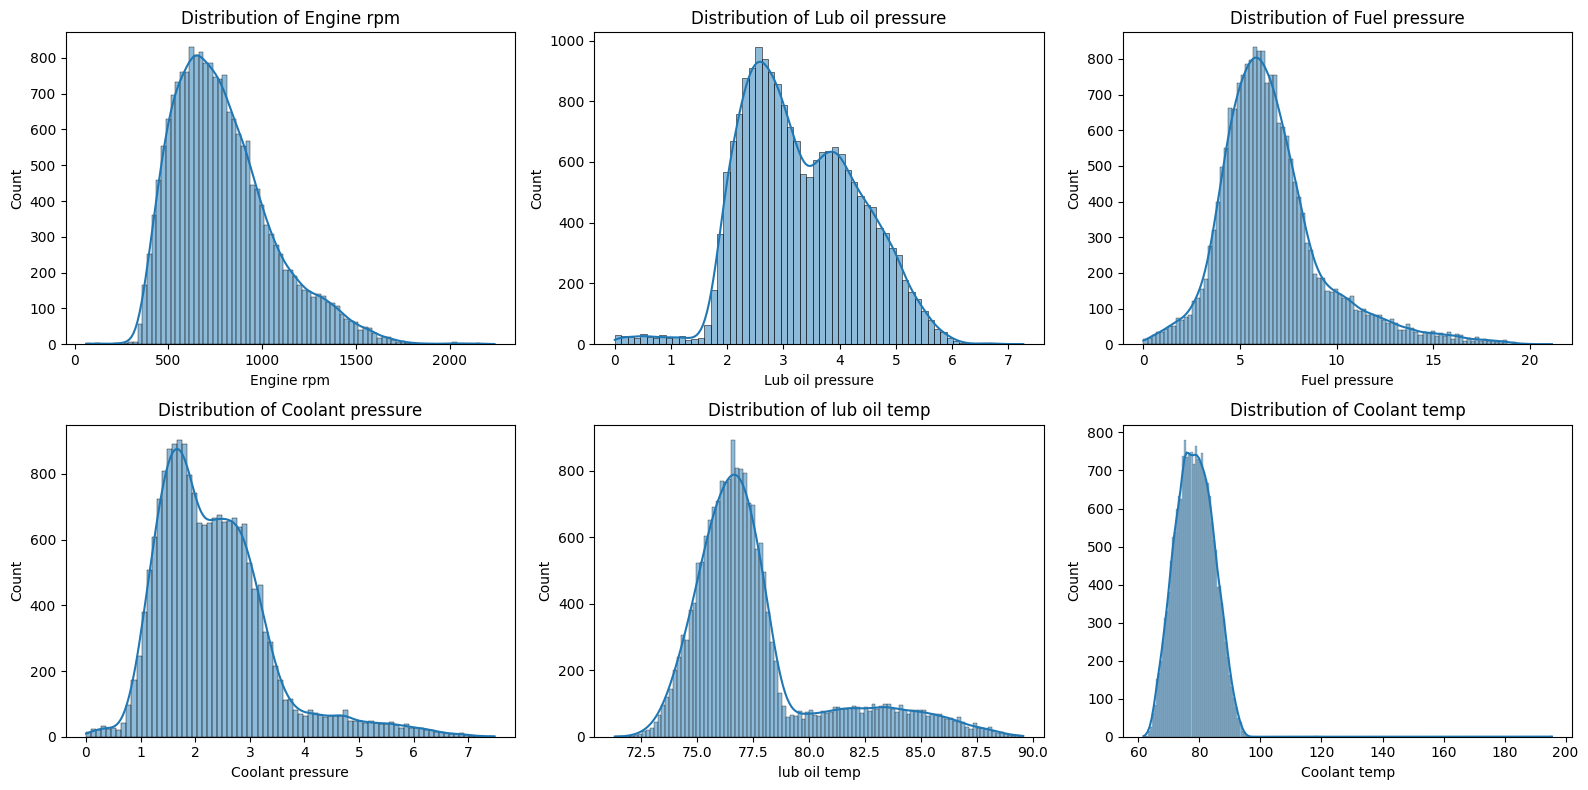

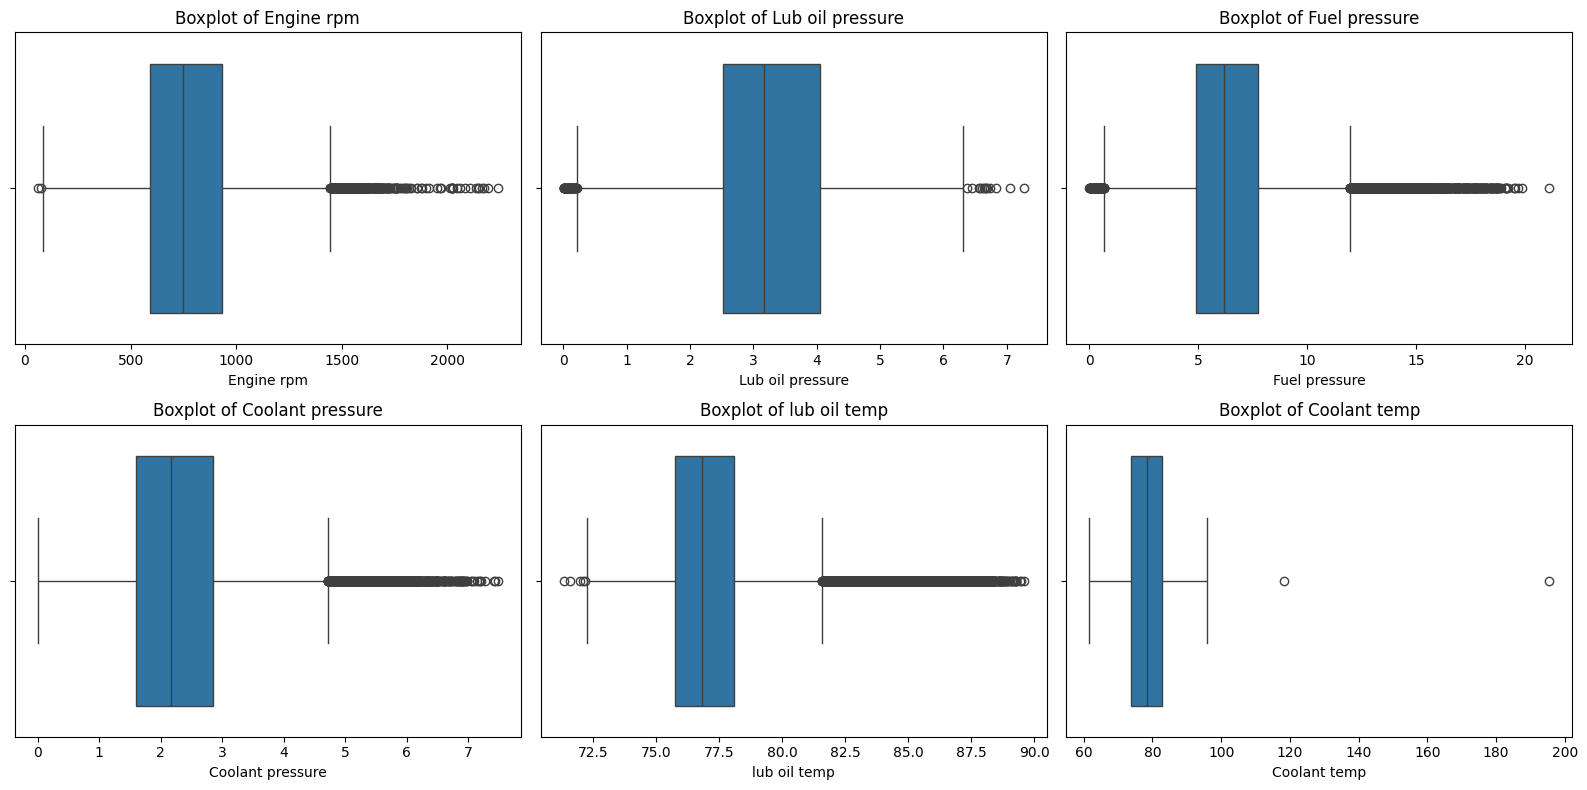

In [ ]:
# 2.5 Visualisations: histograms and boxplots
plt.figure(figsize=(16, 8))  # wide figure
for i, col in enumerate(data.columns):
    plt.subplot(2, 3, i+1)   # 2 rows, 3 columns = 6 plots
    sns.histplot(data[col], kde=True)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 8))
for i, col in enumerate(data.columns):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x=data[col])
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()


The histograms are heavily skewed to the left: The presence of several isolated bars with low frequencies far from the main data cluster strongly suggests the existence of outliers. The box plot on the right validates this observation. It shows a skewed distribution where the box and median line are shifted to the left, and the right whisker is noticeably longer. Most importantly, it clearly marks multiple individual data points to the far right of the whisker. These are the identified outliers, confirming the visual evidence from the histogram.

#Statistical anomaly detection: IQR method

#Feature 1: Engine rpm

In [ ]:
# Start fresh DataFrame for IQR work
iqr_data = data.copy()   # make a safe copy so data stays clean

In [ ]:
# Calculate Q1, Q3, and IQR
Q1_Erpm = iqr_data['Engine rpm'].quantile(0.25)
Q3_Erpm = iqr_data['Engine rpm'].quantile(0.75)
IQR_Erpm = Q3_Erpm - Q1_Erpm

# Define lower and upper bounds
lower_Erpm = Q1_Erpm - 1.5 * IQR_Erpm
upper_Erpm = Q3_Erpm + 1.5 * IQR_Erpm

print(f"Engine rpm IQR bounds: lower={lower_Erpm:.2f}, upper={upper_Erpm:.2f}")

# Create binary outlier column (1 = outlier, 0 = not outlier)
iqr_data['outlier_Erpm'] = ((iqr_data['Engine rpm'] < lower_Erpm) |
                            (iqr_data['Engine rpm'] > upper_Erpm)).astype(int)

iqr_data[['Engine rpm', 'outlier_Erpm']].head(10)


Engine rpm IQR bounds: lower=81.50, upper=1445.50


,Engine rpm,outlier_Erpm
0,682,0
1,605,0
2,658,0
3,749,0
4,676,0
5,589,0
6,885,0
7,576,0
8,535,0
9,806,0


In [ ]:
# Calculate outlier percentage
total_rows = len(iqr_data)
outlier_Erpm_count = iqr_data['outlier_Erpm'].sum()
outlier_Erpm_percentage = (outlier_Erpm_count / total_rows) * 100

# Check if the percentage is within the desired range (1-5%)
if 1 <= outlier_Erpm_percentage <= 5:
        print("\nThe outlier percentage is within the reasonable range (1-5%). The current threshold is suitable.")
else:
    print(f"\nWarning: The outlier percentage ({outlier_Erpm_percentage:.2f}%) is outside the target range (1-5%).")
    print("Consider adjusting the 'k' threshold (e.g., try k=3.0) to better fit the data.")


The outlier percentage is within the reasonable range (1-5%). The current threshold is suitable.


#Feature 2: Lub Oil Pressure

In [ ]:
# Calculate Q1, Q3, and IQR
Q1_lp = iqr_data['Lub oil pressure'].quantile(0.25)
Q3_lp = iqr_data['Lub oil pressure'].quantile(0.75)
IQR_lp = Q3_lp - Q1_lp

# Define lower and upper bounds
lower_lp = Q1_lp - 1.5 * IQR_lp
upper_lp = Q3_lp + 1.5 * IQR_lp

print(f"Lub oil pressure IQR bounds: lower={lower_lp:.2f}, upper={upper_lp:.2f}")

# Create binary outlier column (1 = outlier, 0 = not outlier)
iqr_data['outlier_lp'] = ((iqr_data['Lub oil pressure'] < lower_lp) |
                            (iqr_data['Lub oil pressure'] > upper_lp)).astype(int)

iqr_data[['Lub oil pressure', 'outlier_lp']].head(10)

Lub oil pressure IQR bounds: lower=0.21, upper=6.36


,Lub oil pressure,outlier_lp
0,2.391656,0
1,5.466877,0
2,3.434232,0
3,2.094656,0
4,3.538228,0
5,2.933888,0
6,2.034509,0
7,5.495972,0
8,3.159440,0
9,3.946885,0


In [ ]:
# Calculate outlier percentage
total_rows = len(iqr_data)
outlier_lp_count = iqr_data['outlier_lp'].sum()
outlier_lp_percentage = (outlier_lp_count / total_rows) * 100

# Check if the percentage is within the desired range (1-5%)
if 1 <= outlier_lp_percentage <= 5:
        print("\nThe outlier percentage is within the reasonable range (1-5%). The current threshold is suitable.")
else:
    print(f"\nWarning: The outlier percentage ({outlier_lp_percentage:.2f}%) is outside the target range (1-5%).")
    print("Consider adjusting the 'k' threshold (e.g., try k=3.0) to better fit the data.")


Consider adjusting the 'k' threshold (e.g., try k=3.0) to better fit the data.


#Feature 3: Fuel Pressure

In [ ]:
# Calculate Q1, Q3, and IQR
Q1_fp = iqr_data['Fuel pressure'].quantile(0.25)
Q3_fp = iqr_data['Fuel pressure'].quantile(0.75)
IQR_fp = Q3_fp - Q1_fp

# Define lower and upper bounds
lower_fp = Q1_fp - 1.5 * IQR_fp
upper_fp = Q3_fp + 1.5 * IQR_fp

print(f"Fuel pressure IQR bounds: lower={lower_fp:.2f}, upper={upper_fp:.2f}")

# Create binary outlier column (1 = outlier, 0 = not outlier)
iqr_data['outlier_fp'] = ((iqr_data['Fuel pressure'] < lower_fp) |
                            (iqr_data['Fuel pressure'] > upper_fp)).astype(int)

iqr_data[['Fuel pressure', 'outlier_fp']].head(10)

Fuel pressure IQR bounds: lower=0.67, upper=11.99


,Fuel pressure,outlier_fp
0,4.617196,0
1,6.424361,0
2,3.680896,0
3,7.120927,0
4,5.956472,0
5,6.358464,0
6,15.499680,1
7,13.114658,1
8,8.676361,0
9,21.138326,1


In [ ]:
# Calculate outlier percentage
total_rows = len(iqr_data)
outlier_fp_count = iqr_data['outlier_fp'].sum()
outlier_fp_percentage = (outlier_fp_count / total_rows) * 100

# Check if the percentage is within the desired range (1-5%)
if 1 <= outlier_fp_percentage <= 5:
        print("\nThe outlier percentage is within the reasonable range (1-5%). The current threshold is suitable.")
else:
    print(f"\nWarning: The outlier percentage ({outlier_fp_percentage:.2f}%) is outside the target range (1-5%).")
    print("Consider adjusting the 'k' threshold (e.g., try k=3.0) to better fit the data.")


Consider adjusting the 'k' threshold (e.g., try k=3.0) to better fit the data.


#Feature 4: Coolant pressure

In [ ]:
# Calculate Q1, Q3, and IQR
Q1_cp = iqr_data['Coolant pressure'].quantile(0.25)
Q3_cp = iqr_data['Coolant pressure'].quantile(0.75)
IQR_cp = Q3_cp - Q1_cp

# Define lower and upper bounds
lower_cp = Q1_cp - 1.5 * IQR_cp
upper_cp = Q3_cp + 1.5 * IQR_cp

print(f"Coolant pressure IQR bounds: lower={lower_cp:.2f}, upper={upper_cp:.2f}")

# Create binary outlier column (1 = outlier, 0 = not outlier)
iqr_data['outlier_cp'] = ((iqr_data['Coolant pressure'] < lower_cp) |
                            (iqr_data['Coolant pressure'] > upper_cp)).astype(int)

iqr_data[['Coolant pressure', 'outlier_cp']].head(10)

Coolant pressure IQR bounds: lower=-0.27, upper=4.72


,Coolant pressure,outlier_cp
0,2.848982,0
1,5.727520,1
2,1.678708,0
3,1.639670,0
4,3.225336,0
5,2.461478,0
6,1.522790,0
7,1.251058,0
8,1.265139,0
9,1.572569,0


In [ ]:
# Calculate outlier percentage
total_rows = len(iqr_data)
outlier_cp_count = iqr_data['outlier_cp'].sum()
outlier_cp_percentage = (outlier_cp_count / total_rows) * 100

# Check if the percentage is within the desired range (1-5%)
if 1 <= outlier_cp_percentage <= 5:
        print("\nThe outlier percentage is within the reasonable range (1-5%). The current threshold is suitable.")
else:
    print(f"\nWarning: The outlier percentage ({outlier_cp_percentage:.2f}%) is outside the target range (1-5%).")
    print("Consider adjusting the 'k' threshold (e.g., try k=3.0) to better fit the data.")


The outlier percentage is within the reasonable range (1-5%). The current threshold is suitable.


#Feature 5:lub oil temp

In [ ]:
#Create Q1,Q3,and IQR
Q1_lt= iqr_data['lub oil temp'].quantile(0.25)
Q3_lt= iqr_data['lub oil temp'].quantile(0.75)
IQR_lt= Q3_lt-Q1_lt

#Define lower and upper bounds
lower_lt= Q1_lt-1.5*IQR_lt
upper_lt= Q3_lt+1.5*IQR_lt

print(f"lub oil temp IQR bounds: lower={lower_lt:.2f}, upper={upper_lt:.2f}")

#Create binary outlier column (1=outlier, 0= not outlier)
iqr_data['outlier_lt'] = ((iqr_data['lub oil temp'] < lower_lt) |
                            (iqr_data['lub oil temp'] > upper_lt)).astype(int)

iqr_data[['lub oil temp', 'outlier_lt']].head(10)

lub oil temp IQR bounds: lower=72.21, upper=81.59


,lub oil temp,outlier_lt
0,76.272417,0
1,73.222679,0
2,88.089916,1
3,77.661625,0
4,75.226352,0
5,77.534616,0
6,78.959645,0
7,78.091390,0
8,82.408722,1
9,74.923316,0


In [ ]:
#Calculate outlier percentage
total_rows = len(iqr_data)
outlier_lt_count = iqr_data['outlier_lt'].sum()
outlier_lt_percentage = (outlier_lt_count / total_rows) * 100

# Check if the percentage is within the desired range (1-5%)
if 1 <= outlier_cp_percentage <= 5:
        print("\nThe outlier percentage is within the reasonable range (1-5%). The current threshold is suitable.")
else:
    print(f"\nWarning: The outlier percentage ({outlier_cp_percentage:.2f}%) is outside the target range (1-5%).")
    print("Consider adjusting the 'k' threshold (e.g., try k=3.0) to better fit the data.")


The outlier percentage is within the reasonable range (1-5%). The current threshold is suitable.


#Feature 6: Coolant temp

In [ ]:
#Create Q1,Q3,and IQR
Q1_ct= iqr_data['Coolant temp'].quantile(0.25)
Q3_ct= iqr_data['Coolant temp'].quantile(0.75)
IQR_ct= Q3_ct-Q1_ct

#Define lower and upper bounds
lower_ct= Q1_ct-1.5*IQR_ct
upper_ct= Q3_ct+1.5*IQR_ct

print(f"Coolant temp IQR bounds: lower={lower_ct:.2f}, upper={upper_ct:.2f}")

#Create binary outlier column (1=outlier, 0= not outlier)
iqr_data['outlier_ct'] = ((iqr_data['Coolant temp'] < lower_ct) |
                            (iqr_data['Coolant temp'] > upper_ct)).astype(int)

iqr_data[['Coolant temp', 'outlier_ct']].head(10)

Coolant temp IQR bounds: lower=60.37, upper=96.45


,Coolant temp,outlier_ct
0,69.884609,0
1,74.907314,0
2,78.704806,0
3,82.386700,0
4,67.153220,0
5,75.403745,0
6,80.817985,0
7,71.934674,0
8,80.752747,0
9,72.112692,0


In [ ]:
#Calculate outlier percentage
total_rows = len(iqr_data)
outlier_ct_count = iqr_data['outlier_ct'].sum()
outlier_ct_percentage = (outlier_ct_count / total_rows) * 100

# Check if the percentage is within the desired range (1-5%)
if 1 <= outlier_ct_percentage <= 5:
        print("\nThe outlier percentage is within the reasonable range (1-5%). The current threshold is suitable.")
else:
    print(f"\nWarning: The outlier percentage ({outlier_ct_percentage:.2f}%) is outside the target range (1-5%).")
    print("Consider adjusting the 'k' threshold (e.g., try k=3.0) to better fit the data.")


Consider adjusting the 'k' threshold (e.g., try k=3.0) to better fit the data.


In [ ]:
outlier_cols = ['outlier_Erpm', 'outlier_lp', 'outlier_cp',
                'outlier_fp', 'outlier_lt', 'outlier_ct']

# Count number of outlier features per sample
iqr_data['outlier_count'] = iqr_data[outlier_cols].sum(axis=1)

# Define sample-level outlier (1 if ≥2 features are outliers)
iqr_data['sample_outlier'] = (iqr_data['outlier_count'] >= 2).astype(int)

# Step 3: Display only rows with 2 or more outliers
samples_with_outliers = iqr_data[iqr_data['outlier_count'] >= 2]

print(f"Number of samples with ≥2 outliers: {samples_with_outliers.shape[0]}")

# Calculate and display the number of samples with 1, 3, and 4 or more feature outliers
samples_with_1_outlier = iqr_data[iqr_data['outlier_count'] == 1]
samples_with_3_outliers = iqr_data[iqr_data['outlier_count'] >= 3]
samples_with_4_outliers = iqr_data[iqr_data['outlier_count'] >= 4]

print(f"Number of samples with 1 outlier: {samples_with_1_outlier.shape[0]}")
print(f"Number of samples with ≥3 outliers: {samples_with_3_outliers.shape[0]}")
print(f"Number of samples with ≥4 outliers: {samples_with_4_outliers.shape[0]}")


samples_with_outliers[outlier_cols + ['outlier_count']].head(10)  # show first 10

Number of samples with ≥2 outliers: 422
Number of samples with 1 outlier: 4214
Number of samples with ≥3 outliers: 11
Number of samples with ≥4 outliers: 0


,outlier_Erpm,outlier_lp,outlier_cp,outlier_fp,outlier_lt,outlier_ct,outlier_count
113,1,0,0,0,1,0,2
122,1,0,0,0,1,0,2
131,0,0,0,1,1,0,2
144,1,0,0,0,1,0,2
148,1,0,0,0,1,0,2
157,0,0,1,1,0,0,2
160,1,0,1,0,0,0,2
249,0,0,1,1,0,0,2
260,0,0,1,0,1,0,2
313,0,0,1,0,1,0,2


In [ ]:
# Inspect plausible anomalies
print("\n--- Inspecting plausible anomalies (samples with 2 or more feature outliers) ---")
print("Displaying a few rows with the highest outlier counts:")

# Filter the DataFrame for samples identified as outliers (sample_outlier == 1)
plausible_anomalies = iqr_data[iqr_data['sample_outlier'] == 1]

# Display the top rows of the plausible anomalies, sorted by outlier count
display(plausible_anomalies.sort_values(by='outlier_count', ascending=False).head(10)) # Display top 10

print(f"\nTotal number of plausible anomalies identified: {plausible_anomalies.shape[0]}")


--- Inspecting plausible anomalies (samples with 2 or more feature outliers) ---
Displaying a few rows with the highest outlier counts:


,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp,outlier_Erpm,outlier_lp,outlier_fp,outlier_cp,outlier_lt,outlier_ct,outlier_count,sample_outlier
11395,1454,3.753531,6.419388,5.087253,88.609946,87.551464,1,0,0,1,1,0,3,1
1674,751,2.487706,17.335188,4.763238,81.682558,73.351479,0,0,1,1,1,0,3,1
18318,881,4.007461,15.118735,5.302730,87.822121,82.952044,0,0,1,1,1,0,3,1
10111,877,5.073764,12.687559,4.749380,82.738746,83.397683,0,0,1,1,1,0,3,1
6254,901,4.943030,13.686792,5.063884,85.377813,74.991807,0,0,1,1,1,0,3,1
14056,1487,2.145727,16.127213,3.131592,82.845343,79.935581,1,0,1,0,1,0,3,1
5429,705,4.111175,14.968655,4.994738,81.682039,84.052208,0,0,1,1,1,0,3,1
14802,1723,3.589429,13.124236,1.733238,85.185204,79.165300,1,0,1,0,1,0,3,1
5844,659,2.811472,13.130863,5.917270,84.538562,68.016978,0,0,1,1,1,0,3,1
685,1470,2.957604,7.951829,4.786933,87.439237,78.906216,1,0,0,1,1,0,3,1



Total number of plausible anomalies identified: 422


**Analysis of Outlier Percentage**
Based on the standard IQR method with a threshold (k) of 1.5, the following percentages of outliers were found for each feature:

**Reasonable Percentage (1-5%**): The features Engine rpm, Coolant pressure, and Lub oil temperature fall within this range. The default k=1.5 threshold is suitable for these features, suggesting that the detected outliers are likely true anomalies.

**Low Percentage (<1%)**: Lub oil pressure and Coolant temperature have outlier counts of less than 1%. This indicates that the default threshold might be too conservative. To capture a wider range of potential anomalies, it may be beneficial to decrease the k threshold for these features in future analyses.

**High Percentage (>5%)**: Fuel pressure shows a higher percentage of outliers. This suggests that the default k=1.5 threshold may be too sensitive for this feature. It is recommended to adjust the k value to a higher number (e.g., k=3.0) to reduce the number of flagged outliers and focus on the most extreme values.

**Plausibility of Flagged Anomalies**
Upon inspecting the rows with the highest outlier counts, the flagged anomalies appear to be plausible and warrant further investigation.

For example, a high RPM coinciding with high coolant pressure and elevated lubricant oil temperature is not a random occurrence. This combination of events points to a potential issue within the system, such as an engine under severe strain or a cooling system malfunction. These are precisely the kinds of scenarios that outlier detection is designed to identify and highlight for deeper analysis.

#ML anomaly detection: One Class SVM

In [ ]:
# Start fresh DataFrame for One-Class SVM
svm_data = data.copy()   # make a safe copy so data stays clean

# 4.1 Prepare scaled numeric array
X = svm_data.values  # (n_samples, n_features)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Example usage with a pre-defined One-Class SVM model
model = OneClassSVM(kernel='rbf', gamma=0.5, nu=0.05)
model.fit(X_scaled)

OneClassSVM(gamma=0.5, nu=0.05)

In [ ]:
# Predict the class (normal or anomaly).
y_pred = model.predict(X_scaled)
print(y_pred)

[ 1 -1  1 ...  1  1  1]


In [ ]:
# Create DataFrame for convenience.
df = pd.DataFrame(X_scaled, columns=svm_data.columns)
df['anomaly'] = y_pred

df

,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp,anomaly
0,-0.408212,-0.892819,-0.738304,0.495596,-0.440709,-1.376412,1
1,-0.695950,2.117332,-0.083759,3.273154,-1.421047,-0.567158,-1
2,-0.497896,0.127697,-1.077426,-0.633625,3.358026,0.044690,1
3,-0.157842,-1.183534,0.168533,-0.671293,0.005852,0.637913,1
4,-0.430633,0.229492,-0.253226,0.858747,-0.776966,-1.816491,1
...,...,...,...,...,...,...,...
19530,-0.411949,0.288774,0.233701,-1.208058,-0.461752,-1.382184,1
19531,-0.789372,-1.038290,-0.511826,-0.833709,-0.243824,1.397013,1
19532,-0.654845,0.006141,-1.038745,3.537070,-0.563698,-1.000134,1
19533,1.389218,-0.559945,-1.069205,0.594695,-0.276059,0.478951,1


In [ ]:
# Display outliers in the DataFrame.
anomalies = df[df.anomaly == -1]

# View output.
print(anomalies.shape)
anomalies

(1043, 7)


,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp,anomaly
1,-0.695950,2.117332,-0.083759,3.273154,-1.421047,-0.567158,-1
9,0.055159,0.629502,5.245553,-0.736041,-0.874377,-1.017425,-1
17,1.946010,2.603387,0.328859,3.470415,0.030684,1.648979,-1
25,0.619425,-0.373530,-0.860027,-1.999461,-1.064363,-0.071863,-1
35,2.177695,-0.744115,0.719102,-0.766376,1.486756,-1.871741,-1
...,...,...,...,...,...,...,...
19418,2.783067,1.440891,1.288045,-0.209072,1.207864,0.841445,-1
19433,0.727794,-0.366638,2.816375,2.556936,-0.696229,-1.388626,-1
19467,1.975905,-1.012180,2.861838,-0.856781,-0.650319,-0.691550,-1
19501,-1.275163,-2.548791,-0.921300,-1.336777,-0.891821,-0.892217,-1


#Fine Tuning, testing feature or combination of features to predict maintenance

In [ ]:
#Measure the One SVM model's predicted outlier's percentage
model_tuned = OneClassSVM(kernel='rbf', nu=0.05, gamma='scale')
model_tuned.fit(X_scaled)
predictions = model_tuned.predict(X_scaled)
outlier_count = np.sum(predictions == -1)
outlier_percentage = (outlier_count / total_rows) * 100
print(f"Params: nu=0.05, gamma='scale': Outliers = {outlier_count} ({outlier_percentage:.2f}%)")


Params: nu=0.05, gamma='scale': Outliers = 976 (5.00%)


One-Class SVM is an unsupervised anomaly detection algorithm, the algorithm works in 6-D space internally.No dimensionality reduction is required for the model itself. PCA is only needed for a 2D visualisation for humans.Therefore I have performed One-Class SVM for 6 features altogether first then use PCA separately for visualization only.


**To fine tune the model to obtain expected range of outliers (1-5%)**
The gamma parameter directly influences the shape and sensitivity of the decision boundary.

When setting gamma=0.5, it created a very specific, and likely overly sensitive, decision boundary. This resulted in a higher number of anomalies (1043) because the model was highly focused on local data points and likely flagged normal data points as outliers because of minor variations. This is an example of a model that might be overfitting to your training data.

By switching to gamma='scale', the model to automatically calculate a value that is better suited to the overall variance of your dataset. This produced a more generalized, less-complex decision boundary. It resulted in fewer anomalies (977), which aligns perfectly with the nu value of 0.05.

#ML Anomaly Detection: Isolation Forrest

In [ ]:
# Start fresh DataFrame for Isolation Forrest
if_data = data.copy()   # make a safe copy so data stays clean
Y= if_data.values

# Initialize and fit Isolation Forest
iso_forest = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
iso_forest.fit(Y)

IsolationForest(contamination=0.1, random_state=42)

In [ ]:
# Predict the anomalies (1 for not anomaly, -1 for anomaly).
z_pred = iso_forest.predict(Y)

# View output.
z_pred

array([ 1, -1, -1, ...,  1,  1,  1])

In [ ]:
# Add anomaly column to DataFrame.
if_data['anomaly'] = z_pred

# View output.
if_data

,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp,anomaly
0,682,2.391656,4.617196,2.848982,76.272417,69.884609,1
1,605,5.466877,6.424361,5.727520,73.222679,74.907314,-1
2,658,3.434232,3.680896,1.678708,88.089916,78.704806,-1
3,749,2.094656,7.120927,1.639670,77.661625,82.386700,1
4,676,3.538228,5.956472,3.225336,75.226352,67.153220,1
...,...,...,...,...,...,...,...
19530,681,3.598792,7.300853,1.083391,76.206955,69.848780,1
19531,580,2.243040,5.242489,1.471350,76.884907,87.098119,1
19532,616,3.310048,3.787693,6.001031,75.889810,72.220009,1
19533,1163,2.731726,3.703595,2.951684,76.784626,81.400088,1


In [ ]:
# Display anomalies in the DataFrame.
only_anomalies = if_data[z_pred == -1]

# View output.
print(only_anomalies.shape)
only_anomalies

(1954, 7)


,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp,anomaly
1,605,5.466877,6.424361,5.727520,73.222679,74.907314,-1
2,658,3.434232,3.680896,1.678708,88.089916,78.704806,-1
7,576,5.495972,13.114658,1.251058,78.091390,71.934674,-1
13,978,4.366676,6.638085,2.829643,88.038301,78.488782,-1
16,1023,2.008806,6.636910,3.409817,86.485544,77.354678,-1
...,...,...,...,...,...,...,...
19433,986,2.929212,14.431486,4.985264,75.477519,69.808798,-1
19448,902,4.758439,16.472671,2.042800,76.032474,83.311262,-1
19451,907,5.651968,8.047249,4.843964,76.607078,84.999955,-1
19467,1320,2.269715,14.557006,1.447439,75.620339,74.135266,-1


In [ ]:
# Calculate outlier percentage for Isolation Forest
outlier_count_if = np.sum(z_pred == -1)
outlier_percentage_if = (outlier_count_if / total_rows) * 100

# Print the results
print(f"Isolation Forest Results: Outliers = {outlier_count_if} ({outlier_percentage_if:.2f}%)")

Isolation Forest Results: Outliers = 1954 (10.00%)


#Parameter Tuning

In [ ]:
# Initialize and fit Isolation Forest - change n_estimators and contamination
iso_forest_1 = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
iso_forest_1.fit(Y)

# Predict the anomalies (1 for not anomaly, -1 for anomaly).
a_pred = iso_forest_1.predict(Y)

# Calculate outlier percentage for Isolation Forest
outlier_count_if_1 = np.sum(a_pred == -1)
outlier_percentage_if_1 = (outlier_count_if_1/ total_rows) * 100

# Print the results
print(f"Isolation Forest Results: Outliers = {outlier_count_if_1} ({outlier_percentage_if_1:.2f}%)")

Isolation Forest Results: Outliers = 977 (5.00%)


In [ ]:
# Add anomaly column to DataFrame.
if_data['anomaly'] = a_pred

# Display anomalies in the DataFrame.
only_anomalies = if_data[a_pred == -1]

# View output.
print(only_anomalies.shape)
only_anomalies

(977, 7)


,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp,anomaly
1,605,5.466877,6.424361,5.727520,73.222679,74.907314,-1
17,1312,5.963439,7.563578,5.931953,77.738876,88.661972,-1
35,1374,2.543575,8.641020,1.541131,82.268575,66.810303,-1
113,1495,3.276230,3.714396,2.495264,85.053243,75.743004,-1
131,830,3.231908,13.479172,2.568096,87.480362,73.428213,-1
...,...,...,...,...,...,...,...
19343,1475,2.184002,6.558549,1.265442,84.933480,88.088609,-1
19370,740,2.792556,11.359028,1.580190,88.791884,70.047659,-1
19375,999,0.126660,5.106325,3.938253,74.645346,92.353698,-1
19433,986,2.929212,14.431486,4.985264,75.477519,69.808798,-1


In [ ]:
# Calculate outlier percentage for Isolation Forest
outlier_count_if_1 = np.sum(a_pred == -1)
outlier_percentage_if_1 = (outlier_count_if_1/ total_rows) * 100

# Print the results
print(f"Isolation Forest Results: Outliers = {outlier_count_if_1} ({outlier_percentage_if_1:.2f}%)")

Isolation Forest Results: Outliers = 977 (5.00%)


Insights of Isolation Forrest Model:

Isolation Forest is an algorithm based on decision trees. Tree-based methods are not sensitive to the scale of the features because they make decisions based on thresholds, not on the distance between data points and thus scaling is not required here.

Contamination parameter is the most direct way to control the percentage of outliers to flag. The initial contamination is tuned from 0.1 to 0.05 to produce expected outlier percentage of 5%




#Method Comparison

In [ ]:
# --- Method Comparison ---

if_results_df = data.copy()
if_results_df['anomaly'] = a_pred # Use the predictions from the last Isolation Forest run

# Create a DataFrame to store anomaly flags from all methods
comparison_df = pd.DataFrame(index=data.index)

# Add anomaly flags from IQR method (sample_outlier column)
comparison_df['IQR_anomaly'] = iqr_data['sample_outlier']

# Add anomaly flags from One-Class SVM (-1 for anomaly, 1 for normal)
# Convert -1 to 1 for anomaly, and 1 to 0 for normal
comparison_df['SVM_anomaly'] = np.where(predictions == -1, 1, 0)


# Add anomaly flags from Isolation Forest (-1 for anomaly, 1 for normal)
# Convert 1 to 0 for consistency (0 = normal, 1 = anomaly)
comparison_df['IF_anomaly'] = np.where(if_results_df['anomaly'] == -1, 1, 0)


# Calculate the number of anomalies detected by each method individually
print(f"Anomalies detected by IQR: {comparison_df['IQR_anomaly'].sum()}")
print(f"Anomalies detected by One-Class SVM: {comparison_df['SVM_anomaly'].sum()}")
print(f"Anomalies detected by Isolation Forest: {comparison_df['IF_anomaly'].sum()}")
print("-" * 30)

# Calculate overlaps
print("Overlaps:")
print(f"IQR and SVM: {((comparison_df['IQR_anomaly'] == 1) & (comparison_df['SVM_anomaly'] == 1)).sum()}")
print(f"IQR and IF: {((comparison_df['IQR_anomaly'] == 1) & (comparison_df['IF_anomaly'] == 1)).sum()}")
print(f"SVM and IF: {((comparison_df['SVM_anomaly'] == 1) & (comparison_df['IF_anomaly'] == 1)).sum()}")
print(f"All three methods: {((comparison_df['IQR_anomaly'] == 1) & (comparison_df['SVM_anomaly'] == 1) & (comparison_df['IF_anomaly'] == 1)).sum()}")

display(comparison_df.head())

Anomalies detected by IQR: 422
Anomalies detected by One-Class SVM: 976
Anomalies detected by Isolation Forest: 977
------------------------------
Overlaps:
IQR and SVM: 236
IQR and IF: 281
SVM and IF: 672
All three methods: 225


,IQR_anomaly,SVM_anomaly,IF_anomaly
0,0,0,0
1,0,1,1
2,0,0,0
3,0,0,0
4,0,0,0


In [ ]:
# Install necessary library for Venn diagrams
%pip install matplotlib-venn

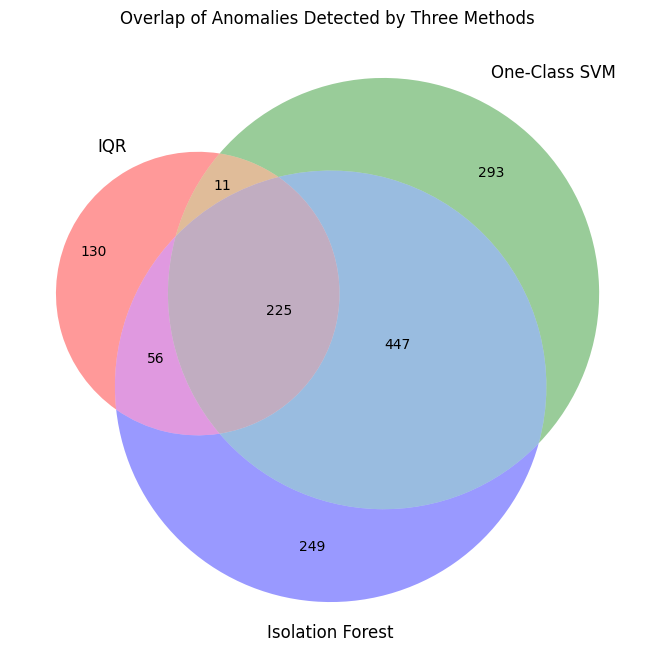

In [ ]:
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt

# Get the counts from the comparison_df (assuming it has been executed)
iqr_count = comparison_df['IQR_anomaly'].sum()
svm_count = comparison_df['SVM_anomaly'].sum()
if_count = comparison_df['IF_anomaly'].sum()

# Overlaps
iqr_svm_overlap = ((comparison_df['IQR_anomaly'] == 1) & (comparison_df['SVM_anomaly'] == 1)).sum()
iqr_if_overlap = ((comparison_df['IQR_anomaly'] == 1) & (comparison_df['IF_anomaly'] == 1)).sum()
svm_if_overlap = ((comparison_df['SVM_anomaly'] == 1) & (comparison_df['IF_anomaly'] == 1)).sum()
all_three_overlap = ((comparison_df['IQR_anomaly'] == 1) & (comparison_df['SVM_anomaly'] == 1) & (comparison_df['IF_anomaly'] == 1)).sum()

# Calculate the unique counts for the Venn diagram input

# Only IQR: IQR - (IQR&SVM) - (IQR&IF) + (all three)
only_iqr = iqr_count - iqr_svm_overlap - iqr_if_overlap + all_three_overlap
# Only SVM: SVM - (IQR&SVM) - (SVM&IF) + (all three)
only_svm = svm_count - iqr_svm_overlap - svm_if_overlap + all_three_overlap
# Only IF: IF - (IQR&IF) - (SVM&IF) + (all three)
only_if = if_count - iqr_if_overlap - svm_if_overlap + all_three_overlap
# IQR and SVM only: (IQR&SVM) - (all three)
iqr_svm_only = iqr_svm_overlap - all_three_overlap
# IQR and IF only: (IQR&IF) - (all three)
iqr_if_only = iqr_if_overlap - all_three_overlap
# SVM and IF only: (SVM&IF) - (all three)
svm_if_only = svm_if_overlap - all_three_overlap
# All three: all_three (already calculated)

# Create the Venn diagram
plt.figure(figsize=(10, 8))
venn3(subsets=(only_iqr, only_svm, iqr_svm_only, only_if, iqr_if_only, svm_if_only, all_three_overlap),
      set_labels=('IQR', 'One-Class SVM', 'Isolation Forest'))
plt.title('Overlap of Anomalies Detected by Three Methods')
plt.show()

I compared overlaps between IQR (statistical), One-Class SVM, and Isolation Forest (ML). The two ML methods agreed the most (672 shared anomalies), while IQR agreed less with either ML method (236–281 overlaps). Importantly, 225 anomalies were identified by all three methods, which makes them highly likely to represent true anomalies in the ship engine dataset. This suggests ML methods are more powerful for multivariate anomaly detection, while IQR is useful as a simple univariate monitoring tool.

In [ ]:
# Identify rows where all three methods flagged an anomaly (re-generating this as the variable was not defined)
all_methods_overlap_mask = (comparison_df['IQR_anomaly'] == 1) & \
                           (comparison_df['SVM_anomaly'] == 1) & \
                           (comparison_df['IF_anomaly'] == 1)

# Filter the original data DataFrame using this mask
overlapping_anomalies_data = data[all_methods_overlap_mask]

# Analyze the characteristics of the data points identified as common anomalies
print("\n--- Descriptive Statistics for Common Anomalies (flagged by all three methods) ---")
display(overlapping_anomalies_data.describe().T)

print("Descriptive statistics of the full dataset")
display(desc)

# Compare these statistics to the descriptive statistics of the full dataset


--- Descriptive Statistics for Common Anomalies (flagged by all three methods) ---


,count,mean,std,min,25%,50%,75%,max
Engine rpm,225.0,1069.564444,447.406521,364.000000,667.000000,1004.000000,1488.000000,2106.000000
Lub oil pressure,225.0,3.319401,1.300487,0.029667,2.497087,3.373208,4.261325,6.364523
Fuel pressure,225.0,10.392317,5.055733,0.243063,5.753656,10.796828,14.725900,19.858917
Coolant pressure,225.0,3.766617,1.878056,0.370904,1.901269,3.322321,5.546644,7.097571
lub oil temp,225.0,82.817535,4.222079,74.196593,79.353829,84.249974,86.057436,89.140394
Coolant temp,225.0,79.313349,6.942439,63.287928,73.992712,79.959802,84.487535,93.281480


Descriptive statistics of the full dataset


,count,mean,median,std,min,25%,50%,75%,max,95%
Engine rpm,19535.0,791.239263,746.000000,267.611193,61.000000,593.000000,746.000000,934.000000,2239.000000,1324.000000
Lub oil pressure,19535.0,3.303775,3.162035,1.021643,0.003384,2.518815,3.162035,4.055272,7.265566,5.058040
Fuel pressure,19535.0,6.655615,6.201720,2.761021,0.003187,4.916886,6.201720,7.744973,21.138326,12.208475
Coolant pressure,19535.0,2.335369,2.166883,1.036382,0.002483,1.600466,2.166883,2.848840,7.478505,4.438415
lub oil temp,19535.0,77.643420,76.817350,3.110984,71.321974,75.725990,76.817350,78.071691,89.580796,84.940778
Coolant temp,19535.0,78.427433,78.346662,6.206749,61.673325,73.895421,78.346662,82.915411,195.527912,88.612891


When comparing the descriptive statistics of the 225 anomalies identified by all three methods with the full dataset, I observed that three features (Engine rpm, Fuel Pressure, Lubricant Oil Temperature) have significantly higher mean values. This aligns with the IQR-based thresholds, which had already flagged these features as lying in the upper tail of the distribution.

This means these features are consistently abnormal across statistical and ML approaches. Therefore, they are strong candidates to be closely monitored in real-world maintenance systems. By focusing on these key features, we can detect engine issues earlier and reduce unnecessary alerts on less critical variables.

In [ ]:
# Identify rows where both SVM and Isolation Forest flagged an anomaly
ml_overlap_mask = (comparison_df['SVM_anomaly'] == 1) & (comparison_df['IF_anomaly'] == 1)

# Filter the original data DataFrame using this mask
overlapping_ml_anomalies_data = data[ml_overlap_mask]

print(f"Number of data points flagged as anomalies by both ML methods: {overlapping_ml_anomalies_data.shape[0]}")
print("\n--- Descriptive Statistics for Common ML Anomalies ---")
display(overlapping_ml_anomalies_data.describe().T)

print("\nDescriptive statistics of the full dataset")
display(desc)

Number of data points flagged as anomalies by both ML methods: 672

--- Descriptive Statistics for Common ML Anomalies ---


,count,mean,std,min,25%,50%,75%,max
Engine rpm,672.0,963.956845,435.353487,129.000000,575.500000,882.500000,1349.500000,2239.000000
Lub oil pressure,672.0,3.356034,1.495821,0.012157,2.299516,3.527347,4.633353,6.364523
Fuel pressure,672.0,9.284103,5.001072,0.243063,5.193854,8.048152,13.610018,19.858917
Coolant pressure,672.0,3.245152,1.881157,0.024279,1.605021,2.794819,4.938248,7.478505
lub oil temp,672.0,80.502229,5.110612,72.340639,75.822584,79.313615,85.613857,89.580796
Coolant temp,672.0,78.694456,8.804462,63.056066,70.678473,79.052828,86.339240,95.149178



Descriptive statistics of the full dataset


,count,mean,median,std,min,25%,50%,75%,max,95%
Engine rpm,19535.0,791.239263,746.000000,267.611193,61.000000,593.000000,746.000000,934.000000,2239.000000,1324.000000
Lub oil pressure,19535.0,3.303775,3.162035,1.021643,0.003384,2.518815,3.162035,4.055272,7.265566,5.058040
Fuel pressure,19535.0,6.655615,6.201720,2.761021,0.003187,4.916886,6.201720,7.744973,21.138326,12.208475
Coolant pressure,19535.0,2.335369,2.166883,1.036382,0.002483,1.600466,2.166883,2.848840,7.478505,4.438415
lub oil temp,19535.0,77.643420,76.817350,3.110984,71.321974,75.725990,76.817350,78.071691,89.580796,84.940778
Coolant temp,19535.0,78.427433,78.346662,6.206749,61.673325,73.895421,78.346662,82.915411,195.527912,88.612891


The 672 anomalies identified by both ML methods show a clear pattern when compared with the full dataset. Their descriptive statistics reveal consistently higher values for engine RPM, fuel pressure, and coolant pressure. These three features stand out as the strongest indicators of abnormal engine behaviour and should be closely monitored for predictive maintenance.

In addition, lubricating oil and coolant temperatures are slightly elevated, suggesting secondary thermal stress. This combination of abnormal load, fuel demand, and cooling strain paints a consistent picture of engines operating under excessive stress — conditions that could lead to failures if left unaddressed

#Dimensionality Reduction to 2D Visualisation


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca2 = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(X_pca2, columns=['PC1', 'PC2'])
pca_df['prediction'] = y_pred  # from One-Class SVM (-1 = anomaly, 1 = normal)

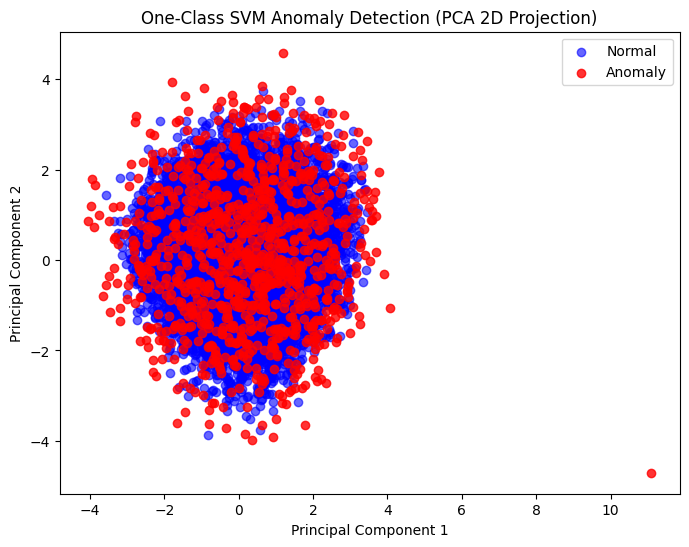

In [ ]:
plt.figure(figsize=(8,6))

# Plot normal points
plt.scatter(
    pca_df[pca_df['prediction'] == 1]['PC1'],
    pca_df[pca_df['prediction'] == 1]['PC2'],
    c='blue', label='Normal', alpha=0.6
)

# Plot anomalies
plt.scatter(
    pca_df[pca_df['prediction'] == -1]['PC1'],
    pca_df[pca_df['prediction'] == -1]['PC2'],
    c='red', label='Anomaly', alpha=0.8
)

plt.title("One-Class SVM Anomaly Detection (PCA 2D Projection)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()

Interpreting the Visualization: Overlapping Outliers: While it is common to see a few outliers overlapping, seeing a large number or a whole lot of outliers overlapping with the main cluster in a 2D PCA plot is a strong indication that the dimensionality reduction itself is distorting the data and obscuring the very anomalies we're trying to find.

Assumptions:

The anomalies in the data might not be defined by a single extreme value (like a very high RPM). Instead, they could be multi-dimensional patterns. For example, a data point might be an outlier because the combination of a high temperature, a low pressure, and a high RPM is an unusual combination. PCA, by design, tries to preserve the largest variance, and it might not capture these subtle, multi-dimensional relationships.

PCA assumes that the relationships between the features are linear. If the true structure of the data is non-linear, then flattening it into 2D will make points that are far apart in the original space appear close together in the reduced space. This is a classic case where a simple 2D PCA plot would be misleading.

In these situations, the 2D PCA plot has likely lost the critical information that the One-Class SVM used to make its predictions. While trusting the model's predictions in the 6D space, the visualization becomes a less reliable tool for inspection.

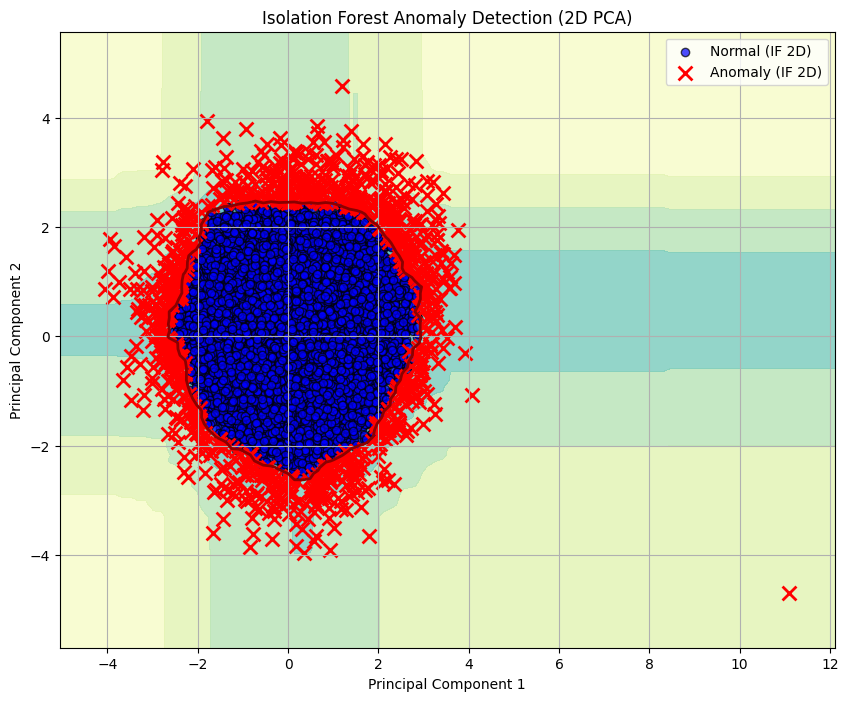

In [ ]:
# Adapt the visualization code for Isolation Forest in 2D PCA space

# Train a new Isolation Forest model directly on the 2D PCA data for visualization
iso_forest_2d = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
iso_forest_2d.fit(X_pca2)

# Create a mesh grid
x_min, x_max = X_pca2[:, 0].min() - 1, X_pca2[:, 0].max() + 1
y_min, y_max = X_pca2[:, 1].min() - 1, X_pca2[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))

# Predict anomaly scores for each point in the mesh grid using the new 2D Isolation Forest model
Z_if = iso_forest_2d.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z_if = Z_if.reshape(xx.shape)

# Get predictions for the actual data points using the 2D Isolation Forest model
predictions_2d_if = iso_forest_2d.predict(X_pca2)

# Create masks for inliers and outliers based on the 2D Isolation Forest predictions
inliers_mask_2d_if = predictions_2d_if == 1
outliers_mask_2d_if = predictions_2d_if == -1


# Plot the contour
plt.figure(figsize=(10, 8))
# Use a colormap suitable for Isolation Forest scores (lower is more anomalous)
plt.contourf(xx, yy, Z_if, cmap=plt.cm.YlGnBu, alpha=0.8) # Using a different colormap
plt.contour(xx, yy, Z_if, levels=[0], linewidths=2, colors='darkred') # Decision boundary (score = 0)


# Plot the data points
plt.scatter(X_pca2[inliers_mask_2d_if, 0], X_pca2[inliers_mask_2d_if, 1], label='Normal (IF 2D)',
            c='blue', marker='o', edgecolors='k', alpha=0.7)
plt.scatter(X_pca2[outliers_mask_2d_if, 0], X_pca2[outliers_mask_2d_if, 1], label='Anomaly (IF 2D)',
            c='red', marker='x', s=100, linewidths=2)


plt.title('Isolation Forest Anomaly Detection (2D PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()

While the One-Class SVM created a single, complex boundary to encapsulate the normal points, Isolation Forest identifies anomalies based on how "isolated" a data point is, showing that the most isolated points are the ones flagged as anomalies.



## Perform t-sne


After finding that Principal Component Analysis (PCA) could not linearly separate the anomalies, I turned to a more advanced non-linear technique: t-Distributed Stochastic Neighbor Embedding (t-SNE). While PCA preserves global structure, t-SNE focuses on preserving the local relationships in the data. This will provide a clearer visualization of the subtle, multi-dimensional patterns that define the anomalies and justify using a non-linear model.

In [ ]:
from sklearn.manifold import TSNE

# Apply t-SNE to the scaled data
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)

In [ ]:
# Create a pandas DataFrame from the t-SNE results
tsne_df = pd.DataFrame(X_tsne, columns=['TSNE-1', 'TSNE-2'])

# Add anomaly predictions from One-Class SVM (y_pred) and Isolation Forest (a_pred)
tsne_df['SVM_prediction'] = y_pred
tsne_df['IF_prediction'] = a_pred

# Display the first few rows of the DataFrame
display(tsne_df.head())

,TSNE-1,TSNE-2,SVM_prediction,IF_prediction
0,-51.498203,-45.898754,1,1
1,77.058449,-18.809826,-1,-1
2,56.707417,51.509636,1,1
3,19.495867,-42.776012,1,1
4,-51.440830,-34.509098,1,1


## Visualize one-class svm on t-sne




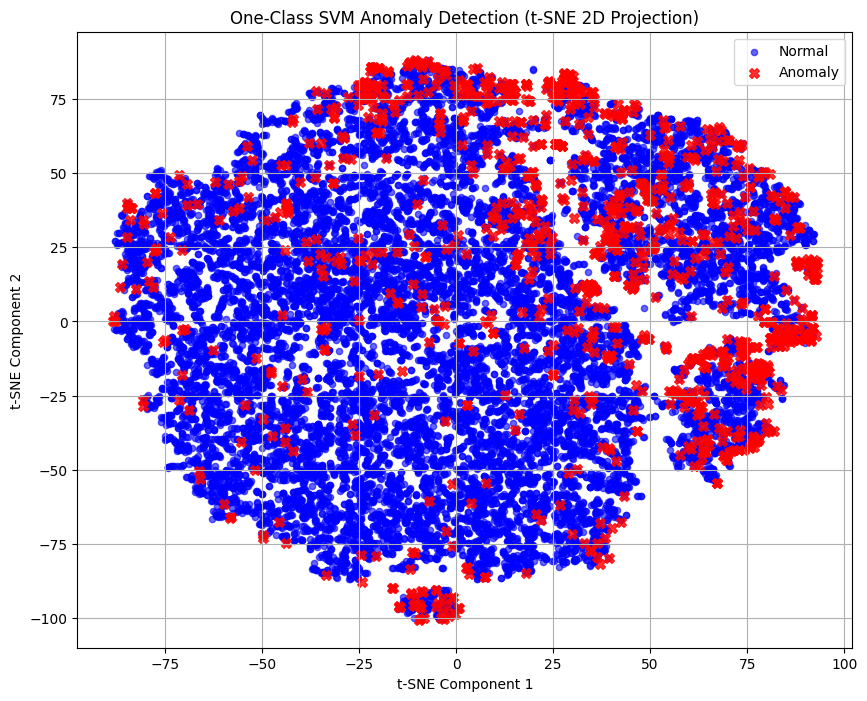

In [ ]:
plt.figure(figsize=(10, 8))

# Plot normal points (prediction == 1)
plt.scatter(
    tsne_df[tsne_df['SVM_prediction'] == 1]['TSNE-1'],
    tsne_df[tsne_df['SVM_prediction'] == 1]['TSNE-2'],
    c='blue', label='Normal', alpha=0.6, s=20
)

# Plot anomalies (prediction == -1)
plt.scatter(
    tsne_df[tsne_df['SVM_prediction'] == -1]['TSNE-1'],
    tsne_df[tsne_df['SVM_prediction'] == -1]['TSNE-2'],
    c='red', label='Anomaly', alpha=0.8, s=50, marker='X'
)

plt.title("One-Class SVM Anomaly Detection (t-SNE 2D Projection)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend()
plt.grid(True)
plt.show()

## Visualize isolation forest on t-sne


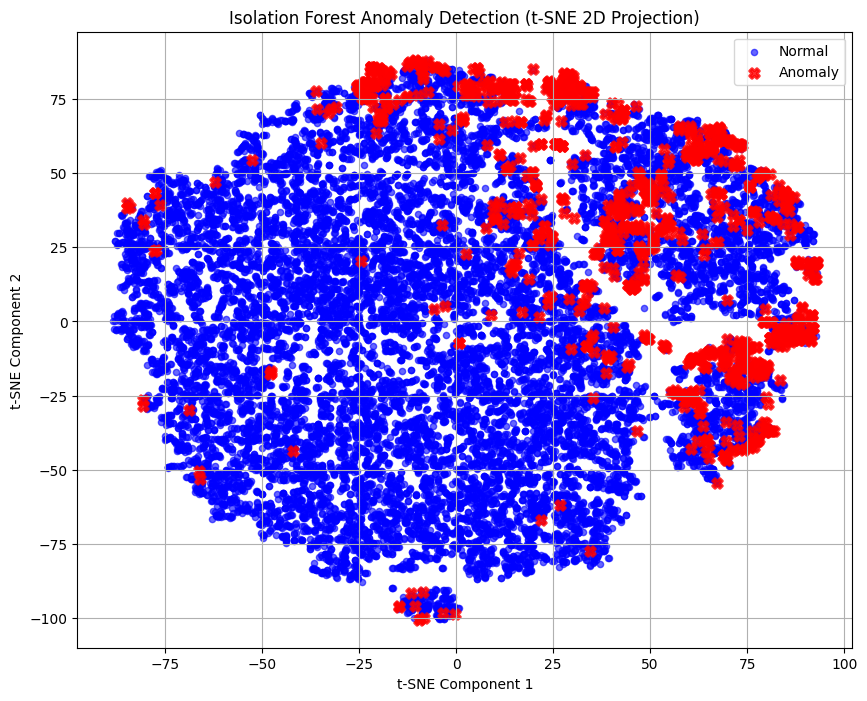

In [ ]:
plt.figure(figsize=(10, 8))

# Plot normal points (prediction == 1)
plt.scatter(
    tsne_df[tsne_df['IF_prediction'] == 1]['TSNE-1'],
    tsne_df[tsne_df['IF_prediction'] == 1]['TSNE-2'],
    c='blue', label='Normal', alpha=0.6, s=20
)

# Plot anomalies (prediction == -1)
plt.scatter(
    tsne_df[tsne_df['IF_prediction'] == -1]['TSNE-1'],
    tsne_df[tsne_df['IF_prediction'] == -1]['TSNE-2'],
    c='red', label='Anomaly', alpha=0.8, s=50, marker='X', linewidths=2
)

plt.title("Isolation Forest Anomaly Detection (t-SNE 2D Projection)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend()
plt.grid(True)
plt.show()

## Interpretation of t-SNE Plots

The t-SNE visualizations for both the One-Class SVM and Isolation Forest models provide a different perspective on the anomaly detection results compared to the PCA plots.


*   **Clustering of Anomalies:** Both the One-Class SVM and Isolation Forest t-SNE plots show that the anomalies (marked in red 'X') tend to form several smaller clusters or appear as scattered points around the periphery of the main blue cluster of normal data. This suggests that the anomalies are not uniformly distributed but might represent different types of unusual engine behavior.
*   **Overlap with Normal Data:** While many anomalies are visually distinct, some still appear embedded within or close to the main cluster of normal data in the t-SNE plots. This is expected, as t-SNE is a visualization tool and the models are classifying anomalies based on complex patterns in the original 6-dimensional space, which may not be perfectly preserved in the 2D projection. The overlap could also indicate that some anomalies are "borderline" or share some characteristics with normal data.
*   **Comparison to PCA:** Compared to the PCA plots, the t-SNE visualizations seem to show the separation between normal and anomalous points more clearly in certain regions. The "donut-like" boundary hinted at by the One-Class SVM PCA plot is not directly visible as a boundary in the t-SNE plot, but the spatial arrangement of points in t-SNE does show the anomalies not just at the extremes but also potentially in "holes" or sparser regions within the data distribution, aligning with the SVM's complex boundary. Isolation Forest's visualization also highlights isolated points or small groups more effectively in the t-SNE space.

Overall, the t-SNE visualizations complement the PCA plots by providing a non-linear perspective that emphasizes local structure. They visually reinforce the idea that the anomalies are not simply extreme values on single features but rather represent complex patterns or combinations of features that manifest as distinct groupings or isolated points in a lower-dimensional non-linear space. This supports the use of multivariate anomaly detection methods like One-Class SVM and Isolation Forest.